## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Resources](#Resources)



<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [62]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [63]:
df = pd.read_csv('ab_data.csv')
df.head()    #The main dataset

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [64]:
row_no = df.shape[0]
print('Dataset number of rows is {}'.format(row_no))

Dataset number of rows is 294478


c. The number of unique users in the dataset.

In [65]:
unique_users = df.user_id.nunique()
print('The number of unique users in the dataset is {}'.format(unique_users))

The number of unique users in the dataset is 290584


d. The proportion of users converted.

In [66]:
general_p_cont = df.converted.mean()
print('The proportion of users converted is {}'.format(general_p_cont))

The proportion of users converted is 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't line up.

In [67]:
miss_match = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0] \
                       + df.query("group == 'control' and landing_page == 'new_page'").shape[0]
print('new_page and treatment don\'t line up {} times'.format(miss_match))

new_page and treatment don't line up 3893 times


f. Do any of the rows have missing values?

In [68]:
null_sum = df.isnull().sum()
null_sum

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [69]:
# aggregate index of mismatched variables and then drop them from dataset
control_index = df.query("group == 'control' and landing_page =='new_page'").index   # mismatched control variables
treatment_index = df.query("group == 'treatment' and landing_page =='old_page'").index  # mismatched treatment variables
index = control_index.append(treatment_index)  #aggregated index
df2 =df.drop(index)  # The new dataset, with no mismatched variables.

In [70]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [71]:
df2_unique_no = df2.user_id.nunique()
print('the number of the new dataset uniques is {}'.format(df2_unique_no))

the number of the new dataset uniques is 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [72]:
df2[df2.user_id.duplicated()].user_id  # Repeated user_id


2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [73]:
df2[df2.user_id.duplicated()]  # The duplicated row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [74]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)   #Dropping the duplicated row..

In [75]:
df2.user_id.duplicated().sum()    #check for duplicates...

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [76]:
p_all_cont = df2.converted.mean()   #probability of all users conversion
p_all_cont

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [77]:
p_cont = df2.query("group == 'control' and converted == 1").shape[0] / \
                   df2.query("group =='control'").shape[0]
print('The conversion probability of control group equals {}'.format(p_cont))

The conversion probability of control group equals 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [78]:
p_trt = df2.query("group == 'treatment' and converted == 1").shape[0] /\
                  df2.query("group =='treatment'").shape[0]
print('The conversion probability of treatment group equals {}'.format(p_trt))

The conversion probability of treatment group equals 0.11880806551510564


d. What is the probability that an individual received the new page?

In [79]:
p_newpage = df2.query("landing_page == 'new_page'").shape[0] / df2.shape[0]
print('Probability of recieving the new page equals {}'.format(p_newpage))

Probability of recieving the new page equals 0.5000619442226688


In [80]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_trt - p_cont
obs_diff

-0.0015782389853555567

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**There is no evidance that new_page has piriority on the old_page; there are almost equal control and treatment group in size and there  is a slight decrease in conversion rate regarding the new page.**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

 $$ H_0 : P_{new} - P_{old}  \leq 0$$
 $$ H_1 : P_{new} - P_{old}  > 0$$

 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [81]:
#under null both groups will have the same conversion rate equal to the dataset conversion rate ...
p_new = df2.converted.mean()  
print('the convert rate for  𝑝𝑛𝑒𝑤  under the null is {}'.format(p_new))

the convert rate for  𝑝𝑛𝑒𝑤  under the null is 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [82]:
#under null both groups will have the same conversion rate equal to the dataset conversion rate ...
p_old = df2.converted.mean()   
print('the convert rate for  𝑝𝑜𝑙𝑑    under the null is {}'.format(p_old))

the convert rate for  𝑝𝑜𝑙𝑑    under the null is 0.11959708724499628


c. What is $n_{new}$?

In [83]:
n_new = df2.query("group == 'treatment'").shape[0]
print('number of individuals in treatment group = {}'.format(n_new))

number of individuals in treatment group = 145310


d. What is $n_{old}$?

In [84]:
n_old = df2.query("group == 'control'").shape[0]
print('number of individuals in control group = {}'.format(n_old))

number of individuals in control group = 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [85]:
#simulation of new_page <> conversion sample
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [86]:
#simulation of old_page <> conversion sample
old_page_converted = np.random.choice([1,0], size = n_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [87]:
diffs = new_page_converted.mean() - old_page_converted.mean()
print('difference between proportions of new and old converted pages = {}'.format(diffs))

difference between proportions of new and old converted pages = -0.0018123084794519628


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [88]:
#another way to estimate p_diffs using random.binomial...
p_diffs = []
new_page_converted = np.random.binomial(n_new,  p_new,  10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs.append(new_page_converted - old_page_converted)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

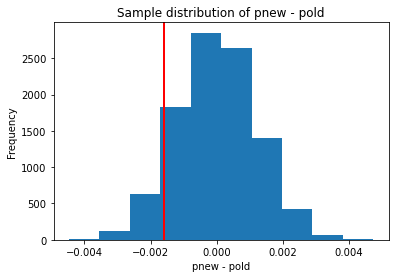

In [89]:
plt.hist(p_diffs);
plt.title('Sample distribution of pnew - pold')
plt.xlabel('pnew - pold')
plt.ylabel('Frequency');
plt.axvline(obs_diff, color = 'r', linewidth = 2)
           


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [90]:
obs_diff

-0.0015782389853555567

In [91]:
#convert p_diffs to array
p_diffs = np.array(p_diffs)

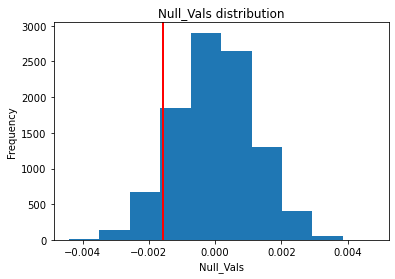

In [92]:
# estimation of the Null_vals which represent the disribution of hypothized null regarding p_diffs std ...
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
# plotting of null_vals Distribution
plt.hist(null_vals);
plt.title('Null_Vals distribution')
plt.xlabel('Null_Vals')
plt.ylabel('Frequency')
plt.axvline(obs_diff, color= 'r', linewidth = 2);

In [93]:
# calculate P_value
p_value = (null_vals > obs_diff).mean()
p_value

0.9064

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

+ **Generating Null Values which are the distribution of The hypothized null value (0) regarding std calculated from p_diffs (Bootstraping and sampling.)**
+ **- calculating P-value which is the probability of acheiving null value and extremities regarding the null hypothesis is true.**
+ **- P_value = 0.9102 which is greater than the value of alpha error (0.05) so we failed to reject the Null Hypothesis.**



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [130]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("group == 'control' and converted == 1").shape[0]

# number of conversions with the new_page
convert_new =df2.query("group == 'treatment' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['group']=='control'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['group']=='treatment'].shape[0]
count = np.array([convert_new, convert_old])
nobs = np.array([n_new,n_old])
n_old , n_new, convert_old, convert_new


(145274, 145310, 17489, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [131]:
#  Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

+ **- values of Z score an P_value consisting with failing to reject the null hypothesis as**
1. Z score < $Z_0.05$ (Right tailed Hypothesis).
2. P_value > 0.05.
+ **- The Findings agree with the fingings of the previous AB test.**

<a id='regression'></a>
### Part III - A regression approach


a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [96]:
# first five raws of the data set
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [97]:
## Generating Dummies of page column variable...
df2[['ab_page','old_page']] = pd.get_dummies(df['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


In [98]:
## predicors and predicted values
X = df2[['intercept', 'ab_page']]
y = df2['converted']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [99]:
## Fitting the Regression model...
log_1 = sm.Logit(y, X)
results = log_1.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [100]:
## Results summary of the regression model
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-04-14 16:30 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [101]:
#reciprocal of coefficient exponentiation 
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

+ **- P_value for ab_page is 0.1899 which suggests that ab_page is not statistically significatn in predecting conversion.**
+ **- Hypothesis related to logistic regression research statistical significane of explainatory variables considering prediction of the response.**
+ **- AB testing hypothesis cares about making a choice regarding two probabilities.**
+ **P_value for logistic regression represents a two tailed hypothesis while p_value for AB test represents a one tailed hypothesis and this explain the difference between them.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

+ **Regarding the dataset informations, Time may play a big influencig role considering status of individuals (control - treatment.)**
+ **advantage of increasing predictors is to increase fitting of the regression model but it also lead to over fitting that may lead to modeling failure and its unability to predict, also mmay increase variance of predictors coeefficient.**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 
Does it appear that country had an impact on conversion? 

In [114]:
# Read the countries.csv
# Join with the df2 dataframe (df_new)
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].unique()


array(['UK', 'US', 'CA'], dtype=object)

In [119]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
### Create the necessary interacted variables...
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 
Provide the summary results, and your conclusions based on the results.

In [120]:
### Fit Your Linear Model And Obtain the Results
log_2 = sm.Logit(df_new['converted'] , df_new[['intercept', 'US', 'US_ab_page', 'UK', 'UK_ab_page', 'ab_page']])
results2 = log_2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-04-14 16:34 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

In [121]:
#coeffecient exponentiation
np.exp(results2.params)

intercept     0.134794
US            1.017682
US_ab_page    1.048001
UK            1.011854
UK_ab_page    1.081428
ab_page       0.934776
dtype: float64

In [122]:
#reciprocal of coefficient exponentiation 
1/np.exp(results2.params)

intercept     7.418713
US            0.982625
US_ab_page    0.954198
UK            0.988285
UK_ab_page    0.924703
ab_page       1.069775
dtype: float64

+ **p_values of predictors (countries and ab_page) > 0.05 and suggests no statistical significance in predictig conversion (Fail to Reject The Null Hypothesis).**
+ **coefficient values of ap_page indicates similarity with old page regarding conversion holding all other predictors     constant.**
+ **coefficient values of Us and UK indicate similarity with CA regarding conversion holding all other predictors     constant.**
+ **coefficient values of interacted ap_page with UK and US indicate similarity with old page regarding conversion holding all other predictors     constant.**
+ **As a final conclousion  we can say that Country has no significane impact on page conversion in addition, although it seems the conversion is similar for old and new pages, old page has a lead for conversion over the new page.**

+ k - Now along with testing if the conversion rate changes for different pages and country a user lives, also add an effect based on Time ...

In [107]:
#How long did take to collect data ?
start = df_new['timestamp'].min()
end = df_new['timestamp'].max()
start , end

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [108]:
#converting TimeStamp to datetime and divide time into weeks
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])
df_new['week'] = df_new['timestamp'].dt.isocalendar().week

In [109]:
#unique values of week column...
df_new['week'].unique()

<IntegerArray>
[2, 4, 3, 1]
Length: 4, dtype: UInt32

In [110]:
### Create the necessary dummy variables
df_new[['week1', 'week2', 'week3', 'week4']] = pd.get_dummies(df_new['week'])

In [111]:
### Fit Your Model And Obtain the Results
log_3 = sm.Logit(df_new['converted'] , df_new[['intercept', 'US', 'UK', 'ab_page','week2', 'week3', 'week4']])
results3 = log_3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366107
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212783.5637
Date:               2022-04-14 16:30 BIC:              212857.6212
No. Observations:   290584           Log-Likelihood:   -1.0638e+05
Df Model:           6                LL-Null:          -1.0639e+05
Df Residuals:       290577           LLR p-value:      0.20338    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9885    0.0156  -127.8568  0.0000  -2.0189  -1.9580
US           -0.0507    0.0284    -1.7842  0.0744  -0.1063   0.0050
UK           -0.0100    0.0133    -0.7549  0.4503  -0.0361   0.0160
ab_page      -0.0149    0.0114    -1.3035  0.1924  -0.0373   0.0075
week2         0.0018    0.0147     0.1215  0.9033  -0.0270   0.0306
week3         0.0195    0.0147     1.3321  0.1828  -0.0092   0.0482
week4         0.0328    0.0237     1.3845  0.1662  -0.0136   0.0792
==================================================================

"""

In [112]:
### coeffecient exponentiation
np.exp(results3.params)

intercept    0.136906
US           0.950603
UK           0.990013
ab_page      0.985205
week2        1.001786
week3        1.019711
week4        1.033349
dtype: float64

+ **p_values of predictors (countries and ab_page) > 0.05 and suggests no statistical significance in predictig conversion\
(Fail to Reject The Null Hypothesis).**
+ **coefficient values of ap_page indicates similarity with old page regarding conversion holding all other predictors 
constant.**
+ **coefficient values of Us and UK indicate similarity with CA regarding conversion holding all other predictors constant.**
+ **coefficient values of week2, week3 and week4 indicate similarity with week1 regarding conversion holding all other\
predictors constant.**
+ **Although Time is not statistically significant, but in practice only 4 weeks are not enough to represent the actual image and\
the recommendation is to expand the test duration.**

<a id='Resources'></a>
### Resources
**Information resources**
+ Udacity literatures.
+ Python standard library.
+ Python documentation.
+ Pandas ,Numbay and Statsmodels documentations.
+ Online web sites like (python, stackoverflow).

**Links for web pages I have used**

+ https://stackoverflow.com/questions/41625077/python-pandas-split-a-timeserie-per-month-or-week
+ https://www.statology.org/null-hypothesis-of-logistic-regression/
+ https://vitalflux.com/two-samples-z-test-for-means-formula-examples/
+ https://stats.stackexchange.com/questions/304707/costs-and-benefits-of-adding-more-variables-to-multiple-regression